https://mer.vin/2024/07/florence-2-fine-tuning-training/

In [4]:
#pip install datasets flash_attn timm einops transformers pillow huggingface_hub

#!pip install flash_attn einops timm
!pip install datasets
# pip install transformers
!pip install timm
# pip install packaging
# pip install wheel
# pip install ninja
!pip install flash_attn
# pip install einops
#!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12

HuggingFaceM4/DocumentVQA

In [5]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoProcessor
import torch
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (AdamW, AutoProcessor, get_scheduler)
from torch.utils.data import Dataset

# 1. Configuration
data = load_dataset("HuggingFaceM4/DocumentVQA")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/39463 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5349 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5188 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/51 [00:00<?, ?it/s]

In [6]:
data

DatasetDict({
    train: Dataset({
        features: ['questionId', 'question', 'question_types', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers'],
        num_rows: 39463
    })
    validation: Dataset({
        features: ['questionId', 'question', 'question_types', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers'],
        num_rows: 5349
    })
    test: Dataset({
        features: ['questionId', 'question', 'question_types', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers'],
        num_rows: 5188
    })
})

Example 1:
Question: what is the date mentioned in this letter?


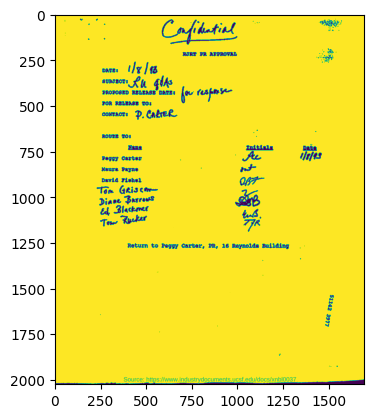

Answers: ['1/8/93']


Example 2:
Question: what is the contact person name mentioned in letter?


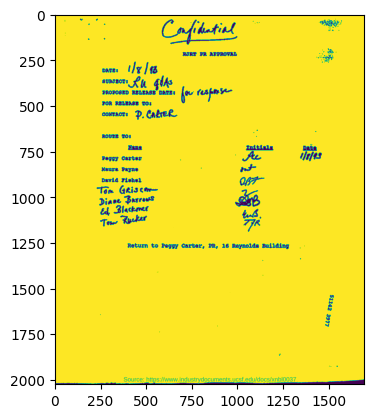

Answers: ['P. Carter', 'p. carter']


Example 3:
Question: Which corporation's letterhead is this?


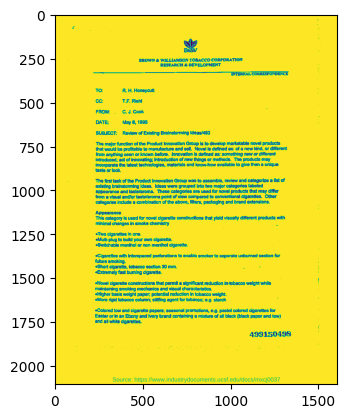

Answers: ['Brown & Williamson Tobacco Corporation']


Example 4:
Question: Who is in  cc in this letter?


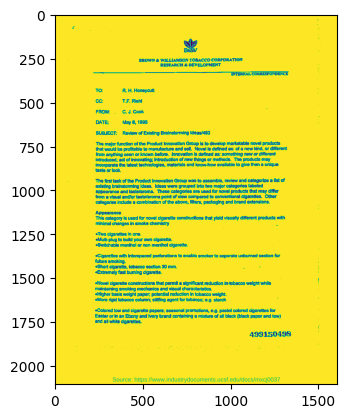

Answers: ['T.F. Riehl']


Example 5:
Question: what is the subject of  this letter?


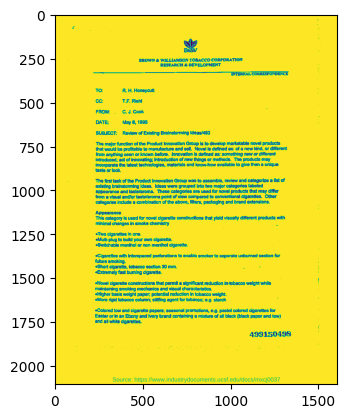

Answers: ['Review of existing Brainstorming Ideas/483']




In [18]:
# Import necessary libraries
from datasets import load_dataset
from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt

# Function to display image in Pli format
def displayimage(image, format='Pli'):


    plt.imshow(image)  # This will display the image as a PIL image
    plt.show()


# Select the first 100 examples from the training set
train_data = data["train"].select(range(100))

# Display sample data with each component
for i, example in enumerate(train_data):
    print(f"Example {i + 1}:")
    print(f"Question: {example['question']}")

    # Display the image
    displayimage(example['image'], format='Pli')

    print(f"Answers: {example['answers']}")
    print("\n" + "="*50 + "\n")  # Separator between examples

    # Optional: limit to first 5 examples
    if i == 4:
        break

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6').to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6')
torch.cuda.empty_cache()

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [8]:

def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer

for idx in range(3):
  print(run_example("DocVQA", 'What do you see in this image?', data['train'][idx]['image']))

{'DocVQA': 'unanswerable'}
{'DocVQA': 'unanswerable'}
{'DocVQA': '499150498'}


In [10]:
"""We need to construct our dataset. Note how we are adding a new task prefix `<DocVQA>` before the question when constructing the prompt."""
class DocVQADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<DocVQA>" + example['question']
        first_answer = example['answers'][0]
        image = example['image']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return question, first_answer, image

train_dataset = DocVQADataset(data['train'].select(range(1000)))
val_dataset = DocVQADataset(data['validation'].select(range(100)))

In [11]:
train_dataset

In [ ]:

# Convert to Embeddings
def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

batch_size = 1
num_workers = 0
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

# 4. Training Model
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, answers = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

# Note: We will freeze image encoder for this tutorial. The authors have reported improvement in unfreezing image encoder, but note that this will result in more resource usage.
for param in model.vision_tower.parameters():
  param.is_trainable = False

train_model(train_loader, val_loader, model, processor, epochs=1)


In [ ]:

# # 5. Save to HuggingFace Hub
# model.push_to_hub("USERNAME/Florence-2-FT-DocVQA")
# processor.push_to_hub("USERNAME/Florence-2-FT-DocVQA")